# MINSET digin recognizer using MLP
#### generalization score 0.94957 

In [1]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#helpers
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [3]:
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')

In [4]:
trainLabels=train.label
train.drop("label",axis=1,inplace=True)

train=train/256.0
test=test/256.0
Xtrain=train.as_matrix()
Xtest=test.as_matrix()

In [5]:
print( Xtrain.shape, trainLabels.shape)

(42000, 784) (42000,)


In [6]:
Xtrain, Xval, trainLabels, valLabels = train_test_split( Xtrain, trainLabels, test_size=0.1,shuffle=True)
ytrain=convert_to_one_hot(trainLabels,10).T
yval=convert_to_one_hot(valLabels,10).T

/home/zein/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
sess = tf.InteractiveSession()

In [8]:
# Define structure of the MLP
input_X = tf.placeholder(tf.float32, shape=(None,28*28))
input_y = tf.placeholder(tf.float32, shape=(None,10))
W1 = tf.get_variable("W1",[28*28,25],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b1 = tf.get_variable("b1",[1,25],initializer=tf.zeros_initializer())
W2 = tf.get_variable("W2",[25,12],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b2 = tf.get_variable("b2",[1,12],initializer=tf.zeros_initializer())
W3 = tf.get_variable("W3",[12,10],initializer=tf.contrib.layers.xavier_initializer(seed=1))
b3 = tf.get_variable("b3",[1,10],initializer=tf.zeros_initializer())

# Forward propagation
a1=tf.nn.relu(tf.add(tf.matmul(input_X,W1),b1))
a2=tf.nn.relu(tf.add(tf.matmul(a1,W2),b2))
predicted_y=tf.nn.sigmoid(tf.add(tf.matmul(a2,W3),b3))
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predicted_y,labels=input_y))

# Backpropogation
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)

# Initialize all the variables
init = tf.global_variables_initializer()
sess.run(init)

In [9]:
Xtrain.shape,ytrain.shape,Xval.shape,yval.shape

((37800, 784), (37800, 10), (4200, 784), (4200, 10))

In [10]:
%%time
# Train the network
N=Xtrain.shape[0] #number of training examples
costs=[]
train_acc=[]
valid_acc=[]

for iteration in range(101):
    sm=0
    k=0
    for i in range(0,N,64):
        _ , patch_cost = sess.run([optimizer,cost],feed_dict={input_X:Xtrain[i:i+64,:],input_y:ytrain[i:i+64,:]})
        k+=1
        sm+=patch_cost
        
    # calculate train accuracy
    trainpred=np.argmax(sess.run(predicted_y,feed_dict={input_X:Xtrain}),axis=1)
    acc1=accuracy_score(trainpred,trainLabels)
    train_acc.append(1-acc1)
    
    # calculate test accuracy
    validpred=np.argmax(sess.run(predicted_y,feed_dict={input_X:Xval}),axis=1)
    acc2=accuracy_score(validpred,valLabels)
    valid_acc.append(1-acc2)
    
    if iteration%10==0:
        print("Cost in iteration #{} = {}".format(iteration,sm/k))
    costs.append(sm/k)

Cost in iteration #0 = 1.716831913050863
Cost in iteration #10 = 1.5036732819681442
Cost in iteration #20 = 1.4921106753615558
Cost in iteration #30 = 1.4874627356198435
Cost in iteration #40 = 1.4847164680510003
Cost in iteration #50 = 1.4831838565429456
Cost in iteration #60 = 1.4823658030650337
Cost in iteration #70 = 1.4814946956037467
Cost in iteration #80 = 1.4800235741029537
Cost in iteration #90 = 1.479460822749259
Cost in iteration #100 = 1.4791898311898994
CPU times: user 3min 1s, sys: 15.2 s, total: 3min 17s
Wall time: 1min 53s


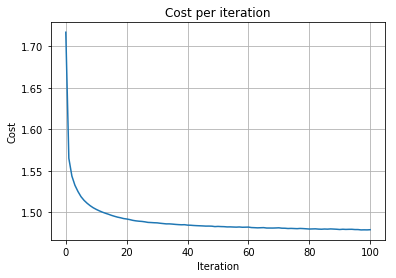

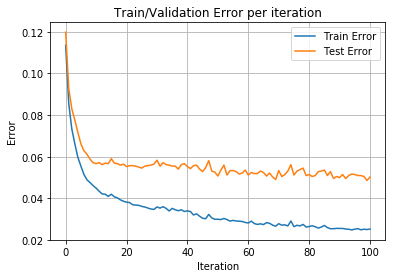

In [11]:
plt.figure("Training costs")
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title("Cost per iteration")
plt.grid()

plt.figure("Train/Validation Error")
plt.plot(train_acc)
plt.plot(valid_acc)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Train/Validation Error per iteration")
plt.legend(['Train Error','Test Error'])
plt.grid()

In [12]:
testpred=np.argmax(sess.run(predicted_y,feed_dict={input_X:Xtest}),axis=1)

ids=np.arange(1,Xtest.shape[0]+1)
df = pd.DataFrame({'ImageId':ids, 'Label': testpred.T})

df.to_csv("output/model2.csv", index=False)